# Worksheet 19

Name:  Ekaterina Azarova

UID: U88633327

### Topics

- Linear Model Evaluation

## Linear Model Evaluation

Notice that R^2 only increases with the number of explanatory variables used. Hence the need for an adjusted R^2 that penalizes for insignificant explanatory variables.

In [25]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

SAMPLE_SIZE = 100
beta = [1, 5]
X = -10.0 + 10.0 * np.random.random(SAMPLE_SIZE)
Y = beta[0] + beta[1] * X + np.random.randn(SAMPLE_SIZE)

for i in range(1, 15):
    X_transform = PolynomialFeatures(degree=i, include_bias=False).fit_transform(X.reshape(-1, 1))
    model = LinearRegression()
    model.fit(X_transform, Y)
    print(model.score(X_transform, Y))

0.9959260912902435
0.9959578377005541
0.99600260807316
0.9960036903796752
0.9960466580157101
0.9961047862287081
0.9961480367075054
0.9962269781453302
0.996292940072285
0.996301360948645
0.99636568292514
0.9963703764743027
0.9963517599149186
0.9964000804114751


a) Hypothesis Testing Sandbox (follow along in class) [Notes](https://medium.com/@gallettilance/hypothesis-testing-almost-everything-you-need-to-know-ce812ded50b)

0.3125
[1, 0, 0, 0, 0]
0.15624999999999994


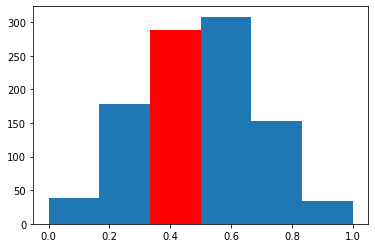

In [26]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

flips = [1, 0, 0, 1, 0]

def num_successes(flips):
    return sum(flips)

print(binom.pmf(num_successes(flips), len(flips), 1/2))

SAMPLE_SIZE = 5
flips = [np.random.choice([0, 1]) for _ in range(SAMPLE_SIZE)]
print(flips)
print(binom.pmf(num_successes(flips), SAMPLE_SIZE, 1/2))

p_est = []

for _ in range(1000):
    flips = [np.random.choice([0, 1]) for _ in range(SAMPLE_SIZE)]
    p_est.append(sum(flips) / SAMPLE_SIZE)

fig, ax = plt.subplots()
_, bins, patches = ax.hist(p_est, bins=SAMPLE_SIZE + 1)
p = np.digitize([2/5], bins)
patches[p[0]-1].set_facecolor('r')
#ax.bar_label(patches)
plt.show()
     

b) Plot a data set and fitted line through the point when there is no relationship between X and y.

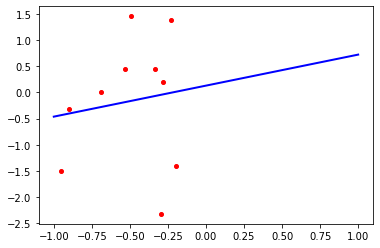

In [27]:
import numpy as np
import matplotlib.pyplot as plt

SAMPLE_SIZE = 10

xlin = -1.0 + 1.0 * np.random.random(SAMPLE_SIZE)
y = 0 + 0 * xlin + np.random.randn(SAMPLE_SIZE)

intercept = np.ones(np.shape(xlin)[0])
X = np.array([intercept, xlin]).T
beta = np.linalg.inv(X.T @ X) @ X.T @ y

xplot = np.linspace(-1,1,20)
yestplot = beta[0] + beta[1] * xplot
plt.plot(xplot, yestplot,'b-',lw=2)
plt.plot(xlin, y,'ro',markersize=4)
plt.show()

c) Using the above code, plot a histogram of the parameter estimates for the slope after generating `1000` independent datasets. Comment on what the plot means. Increase the sample size to see what happens to the plot. Explain.

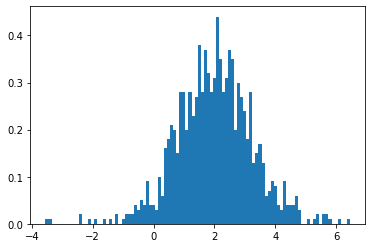

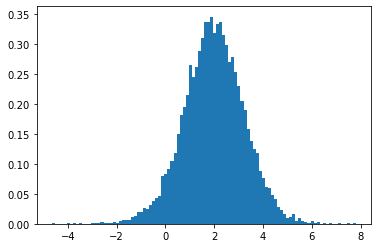

In [28]:
beta_hist = []
for _ in range(1000): # play with different amounts of simulations
    xlin = -1.0 + 1.0 * np.random.random(SAMPLE_SIZE)
    y = 0 + 2.0 * xlin + np.random.randn(SAMPLE_SIZE) # I can play withe the slope
    
    intercept  = np.ones(np.shape(xlin)[0])
    X = np.array([intercept, xlin]).T
    beta_est = np.linalg.inv(X.T @ X) @ X.T @ y
    beta_hist.append(beta_est[1])

fig, ax = plt.subplots()
ax.hist(beta_hist, bins=100, density=True)
plt.show()

beta_hist = []
for _ in range(10000): # play with different amounts of simulations
    xlin = -1.0 + 1.0 * np.random.random(SAMPLE_SIZE)
    y = 0 + 2.0 * xlin + np.random.randn(SAMPLE_SIZE) # I can play withe the slope
    
    intercept  = np.ones(np.shape(xlin)[0])
    X = np.array([intercept, xlin]).T
    beta_est = np.linalg.inv(X.T @ X) @ X.T @ y
    beta_hist.append(beta_est[1])

fig, ax = plt.subplots()
ax.hist(beta_hist, bins=100, density=True)
plt.show()

For each sample set of data points (x_i, y_i) with the length SAMPLE_SIZE = 10, 
we estimate the slope for the relation y = slope*x + noise. In our case, 
the real slope equals 2.0 and the distribution of noise we added is normal, 
with mu = 0.0, sigma = 1. 
If we get many samples of the same relation, we get many slope estimates. 
We expect that the distribution of the slope estimates is also normal, 
with mu = 2.0, sigma = 1. Indeed, we see this on the histogram of slope 
estimates. From the visual comparison, increasing the number of data sets 
from 1000 to 10000 does not change the distribution of the slope estimates: 
it has mu = 2.0, sigma = 1. The quality of the distribution representation 
is better for 10000 data sets. 

d) We know that:

$$\hat\beta-\beta \sim \mathcal{N}(0,\sigma^2 (X^TX)^{-1})$$

thus for each component $k$ of $\hat\beta$ (here there are only two - one slope and one intercept)

$$\hat\beta_k -\beta_k \sim \mathcal{N}(0, \sigma^2 S_{kk})$$

where $S_{kk}$ is the $k^\text{th}$ diagonal element of $(X^TX)^{-1}$. Thus, we know that 

$$z_k = \frac{\hat\beta_k -\beta_k}{\sqrt{\sigma^2 S_{kk}}} \sim \mathcal{N}(0,1)$$

Verify that this is the case through a simulation and compare it to the standard normal pdf by plotting it on top of the histogram.

d): beta_mean, beta_std: 2.022265796851358 1.2398680587227549


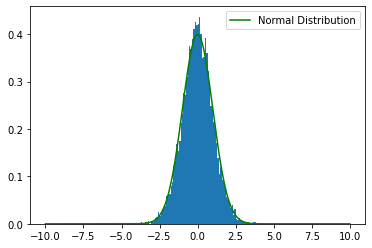

In [29]:
from scipy.stats import norm

beta_hist = []
for _ in range(10000): # play with different amounts of simulations
    xlin = -1.0 + 1.0 * np.random.random(SAMPLE_SIZE)
    y = 0 + 2.0 * xlin + np.random.randn(SAMPLE_SIZE) # I can play with the slope
    
    intercept  = np.ones(np.shape(xlin)[0])
    X = np.array([intercept, xlin]).T
    beta_est = np.linalg.inv(X.T @ X) @ X.T @ y
    beta_hist.append(beta_est[1])

# To compare with known distributions, we normalize beta by subtracting 
# the mean and dividing by the standard deviation. 
beta_mean = np.mean(beta_hist)
beta_std = np.std(beta_hist, dtype=np.float64)
print("d): beta_mean, beta_std:", beta_mean, beta_std)
beta_hist = (beta_hist - beta_mean)/beta_std

xs = np.linspace(-10,10,1000)
fig, ax = plt.subplots()
ax.hist(beta_hist, bins=100, density=True)
ax.plot(xs, norm.pdf(xs), color='green', label='Normal Distribution')
ax.legend()
plt.show()

e) Above we normalized $\hat\beta$ by subtracting the mean and dividing by the standard deviation. While we know that the estimate of beta is an unbiased estimator, we don't know the standard deviation. So in practice when doing a hypothesis test where we want to assume that $\beta = 0$, we can simply use $\hat\beta$ in the numerator. However we don't know the standard deviation and need to use an unbiased estimate of the standard deviation instead. This estimate is the standard error `s`

$$s = \sqrt{\frac{RSS}{n - p}}$$

where p is the number of parameters beta (here there are 2 - one slope and one intercept). This normalized $\hat\beta$ can be shown to follow a t-distribution with `n-p` degrees of freedom. Verify this is the case with a simulation.

e): beta_mean, beta_std: 2.0058201325322096 1.2312435024678297


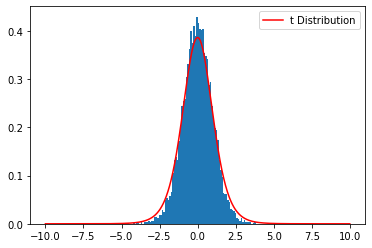

In [30]:
from scipy.stats import t

def standard_error(ytrue, ypred):
    diff_sq = (abs(ytrue - ypred))**2
    diff_sq_sum = np.sum(diff_sq)
    std_error = np.sqrt(diff_sq_sum/(len(ytrue)-2))
    return std_error

beta_hist = []
for _ in range(10000): # play with different amounts of simulations
    xlin = -1.0 + 1.0 * np.random.random(SAMPLE_SIZE)
    y = 0 + 2.0 * xlin + np.random.randn(SAMPLE_SIZE) # I can play with the slope
    
    intercept  = np.ones(np.shape(xlin)[0])
    X = np.array([intercept, xlin]).T
    beta_est = np.linalg.inv(X.T @ X) @ X.T @ y
    beta_hist.append(beta_est[1])
    std_error = standard_error(y, np.mean(beta_hist) * xlin)
    #print("std_error:", std_error)

# To compare with known distributions, we normalize beta by subtracting 
# the mean and dividing by the standard deviation. 
beta_mean = np.mean(beta_hist)
beta_std = np.std(beta_hist, dtype=np.float64)

print("e): beta_mean, beta_std:", beta_mean, beta_std)
beta_hist = (beta_hist - beta_mean)/beta_std

xs = np.linspace(-10,10,1000)
fig, ax = plt.subplots()
ax.hist(beta_hist, bins=100, density=True)
ax.plot(xs, t.pdf(xs, SAMPLE_SIZE - 2), color='red', label='t Distribution')
ax.legend()
plt.show()

f) You are given the following dataset:

f): beta_hat is  [0.50155603 1.19902827]
f): std_error: 1.1699433922245908



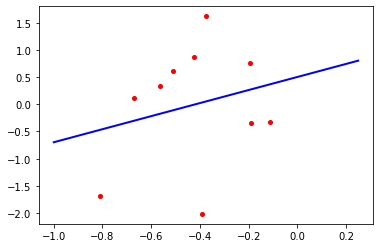

In [31]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([-0.1920605, -0.11290798, -0.56434374, -0.67052057, -0.19233284, -0.42403586, -0.8114285, -0.38986946, -0.37384161, -0.50930229])
y = np.array([-0.34063108, -0.33409286, 0.34245857, 0.11062295, 0.76682389, 0.86592388, -1.68912015, -2.01463592, 1.61798563, 0.60557414])

intercept = np.ones(np.shape(x)[0])
X = np.array([intercept, x]).T
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
std_error = standard_error(y, beta_hat[0] + beta_hat[1] * x)
print("f): beta_hat is ", beta_hat)
print("f): std_error:", std_error)
print()

xplot = np.linspace(-1,.25,20)
yestplot = beta_hat[0] + beta_hat[1] * xplot
plt.plot(xplot, yestplot,'b-',lw=2)
plt.plot(x, y,'ro',markersize=4)
plt.show()

# what is the probability of observing a dataset at least as extreme 
# as the above assuming $\beta = 0$ ?
# HINT FROM CLASS -> just count for how many instances there are 
# of a specific condition... do if statement




what is the probability of observing a dataset at least as extreme as the above assuming $\beta = 0$ ?


The probability of observing a dataset at least as extreme as the given is  0.2640130831114661


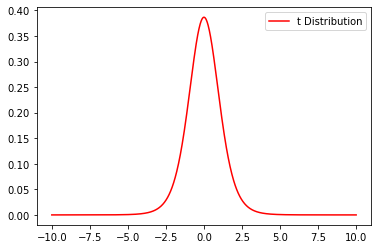

In [33]:
# We observed the sample with the slope: beta_hat[1]. What is the probability 
# to have such beta value if in real it is 0, and we have T-distribution with 
# mean = 0.0 and parameterized by the sample size (SAMPLE_SIZE - 2)? 
# We need to compare the total probability for beta to be inside the interval 
# +-|beta_hat[1]|, and the total probability to be outside the interval 
# +-|beta_hat[1]|. "The total probability" here is the integral under t.pdf() 
# distribution (curve). We can approximate the integrals by summation: 
# calculate areas under the distribution curve. 

SAMPLE_SIZE = 10
xs = np.linspace(-10,10,1000)
fig, ax = plt.subplots()
ax.plot(xs, t.pdf(xs, SAMPLE_SIZE - 2), color='red', label='t Distribution')
ax.legend()
#plt.show()

total_area = 0.0
central_area = 0.0
for x in np.linspace(-10,10,1000):
   val = t.pdf(x, SAMPLE_SIZE - 2)
   total_area += val
   if ( x > -abs(beta_hat[1]) ) and ( x < abs(beta_hat[1]) ) :
     central_area += val

prob_such_extreme_or_worse = 1.0 - central_area/total_area
#print("total_area, central_area: ", total_area, central_area)
print()
print("The probability of observing a dataset at least as extreme as the given is ", prob_such_extreme_or_worse)

